<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400100962
Name = 'Parsa'
Last_Name = 'Hatami'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

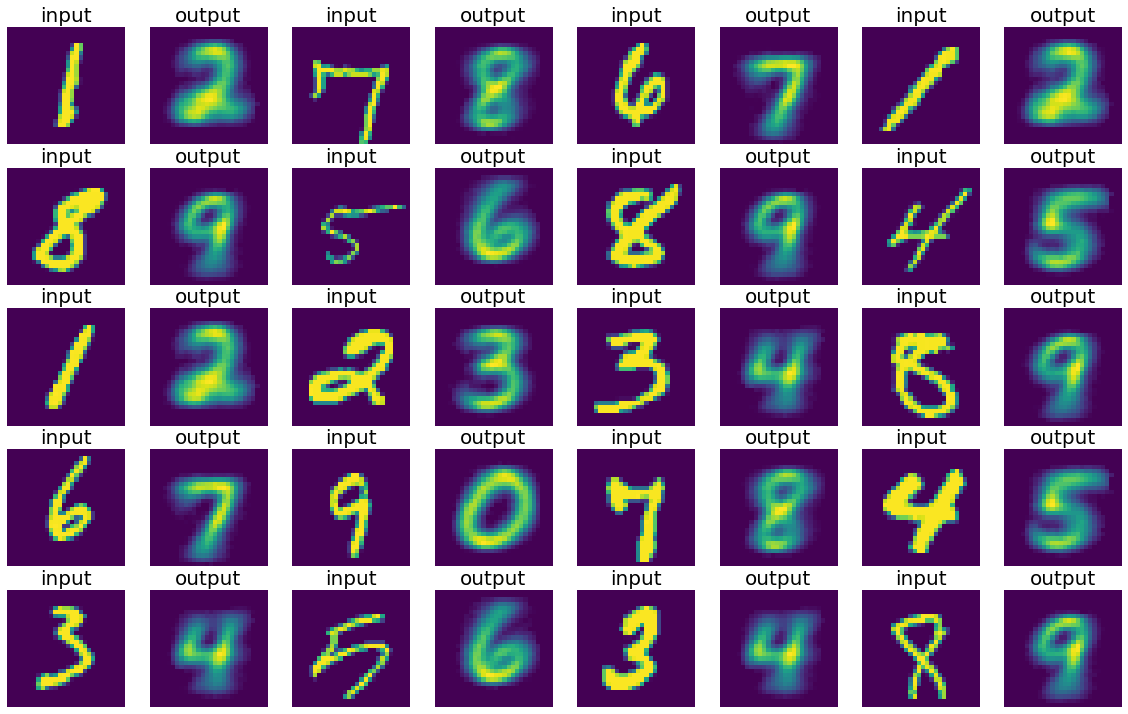

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

i runned the notebook at kaggle because i had problem installing torch so i had copied the ae_helper functions in my notebook to use them

# ae_helper

In [2]:
"""
AUTHOR:         Ahmad Salimi (https://github.com/ahmadsalimi)
"""


from typing import Tuple

from sklearn.datasets import fetch_openml
import numpy as np
import os
import torch
from tqdm import tqdm


def get_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Downloads the MNIST data and processes the data for autoencoder problem.
    
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of input images,
            output images (input + 1), and the label of input images
    """
    X, y = fetch_openml('mnist_784', return_X_y=True, cache=True)
    X, y = X.values, y.values
    X = X.reshape(-1, 28, 28).astype('float32') / 255.0
    y = y.astype(int)

    Y = np.zeros_like(X)
    ind = y.argsort()
    X, y = X[ind], y[ind]

    c = 0
    for i in range(10):
        s = (y == i).sum()
        ss = (y == (i + 1) % 10).sum()
        if s <= ss:
            Y[c:c+s] = X[c+s:c+2*s]
        elif i < 9:
            Y[c:c+ss] = X[c+s:c+s+ss]
            Y[c+ss:c+s] = X[c+s:c+2*s-ss]
        else:
            Y[c:c+ss] = X[:ss]
            Y[c+ss:c+s] = X[:s-ss]
        c += s

    current_state = np.random.get_state()

    np.random.seed(10)
    ind = np.random.permutation(X.shape[0])
    X, Y, y = X[ind], Y[ind], y[ind]

    np.random.set_state(current_state)

    return X, Y, y

def init_mnist_subset_directories(mnist_dataset, dataset_path, subset_size=5000):
    mnist_subset = torch.utils.data.Subset(mnist_dataset, torch.randperm(len(mnist_dataset))[:subset_size])

    os.mkdir(dataset_path)
  
    for idx, (x, y) in enumerate(tqdm(mnist_subset)):
        label_path = os.path.join(dataset_path, str(y))
        if not os.path.exists(label_path):
            os.mkdir(label_path)
        torch.save(x, os.path.join(label_path, 'data_'+str(idx)+'.pth'))


## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [3]:
#from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList([
            nn.Linear(in_features=784, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=150),
            nn.ReLU(),
            nn.Linear(in_features=150, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=20)
        ])
        
        # Decoder
        self.decoder_layers = nn.ModuleList([
            nn.Linear(in_features=20, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=150),
            nn.ReLU(),
            nn.Linear(in_features=150, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=784),
            nn.Sigmoid()
        ])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten the input
        x = x.view(x.size(0), -1)
        
        # Pass through encoder
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Pass through decoder
        for layer in self.decoder_layers:
            x = layer(x)
        
        # Reshape to image format
        x = x.view(x.size(0), 1, 28, 28)
        
        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [5]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [6]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [7]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    total_loss = 0.0
    loss_function = nn.MSELoss()

    for batch_idx, (input_data, target_data, _) in enumerate(dataloader):
        input_data = input_data.to(device)
        target_data = target_data.to(device)

        optimizer.zero_grad()
        reconstructed = model(input_data)
        
        reconstructed = reconstructed.view_as(input_data)
        
        loss = loss_function(reconstructed, target_data)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_data.size(0)

    average_loss = total_loss / len(dataloader.dataset)
    
    return average_loss



def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    total_loss = 0.0
    loss_function = nn.MSELoss()

    with torch.no_grad():
        for batch_idx, (input_data, target_data, _) in enumerate(dataloader):
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            reconstructed = model(input_data)
            
            reconstructed = reconstructed.view_as(input_data)
            
            loss = loss_function(reconstructed, target_data)
            total_loss += loss.item() * input_data.size(0)

    average_loss = total_loss / len(dataloader.dataset)
    
    return average_loss


## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [8]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [9]:
import torch
import os
import matplotlib.pyplot as plt

class AutoencoderTrainer:
    def __init__(self, model, optimizer, train_dataloader, val_dataloader, num_epochs=20):
        self.model = model
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.num_epochs = num_epochs
        self.best_val_loss = float('inf')
        self.best_model_weights = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def calculate_accuracy(self, dataloader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in dataloader:
                inputs = data[0]
                inputs_flat = inputs.view(inputs.size(0), -1)
                outputs = self.model(inputs_flat)
                predicted = outputs.view_as(inputs)
                predicted_binary = (predicted > 0.5).float()
                inputs_binary = (inputs > 0.5).float()
                total += inputs.numel()
                correct += (predicted_binary == inputs_binary).sum().item()
        return correct / total

    def train(self):
        for epoch in range(self.num_epochs):
            train_loss = train_autoencoder(self.model, self.optimizer, self.train_dataloader)
            val_loss = eval_autoencoder(self.model, self.val_dataloader)

            train_accuracy = self.calculate_accuracy(self.train_dataloader)
            val_accuracy = self.calculate_accuracy(self.val_dataloader)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_accuracies.append(val_accuracy)

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_weights = self.model.state_dict()

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        if self.best_model_weights is not None:
            os.makedirs('model_checkpoints', exist_ok=True)
            torch.save(self.best_model_weights, 'autoencoder.pth')
            print(f'Best model saved with validation loss: {self.best_val_loss:.4f}')

trainer = AutoencoderTrainer(ae, optimizer, train_dataloader, val_dataloader)
trainer.train()

Epoch [1/20], Train Loss: 0.0840, Val Loss: 0.0671, Train Acc: 0.8678, Val Acc: 0.8681
Epoch [2/20], Train Loss: 0.0662, Val Loss: 0.0650, Train Acc: 0.8605, Val Acc: 0.8608
Epoch [3/20], Train Loss: 0.0619, Val Loss: 0.0593, Train Acc: 0.8473, Val Acc: 0.8475
Epoch [4/20], Train Loss: 0.0579, Val Loss: 0.0569, Train Acc: 0.8431, Val Acc: 0.8429
Epoch [5/20], Train Loss: 0.0564, Val Loss: 0.0561, Train Acc: 0.8398, Val Acc: 0.8396
Epoch [6/20], Train Loss: 0.0557, Val Loss: 0.0556, Train Acc: 0.8438, Val Acc: 0.8437
Epoch [7/20], Train Loss: 0.0553, Val Loss: 0.0554, Train Acc: 0.8409, Val Acc: 0.8410
Epoch [8/20], Train Loss: 0.0550, Val Loss: 0.0552, Train Acc: 0.8419, Val Acc: 0.8419
Epoch [9/20], Train Loss: 0.0548, Val Loss: 0.0551, Train Acc: 0.8422, Val Acc: 0.8423
Epoch [10/20], Train Loss: 0.0547, Val Loss: 0.0550, Train Acc: 0.8404, Val Acc: 0.8404
Epoch [11/20], Train Loss: 0.0545, Val Loss: 0.0551, Train Acc: 0.8401, Val Acc: 0.8400
Epoch [12/20], Train Loss: 0.0544, Val Lo

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [10]:
####
ae.load_state_dict(torch.load('autoencoder.pth'))
####

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

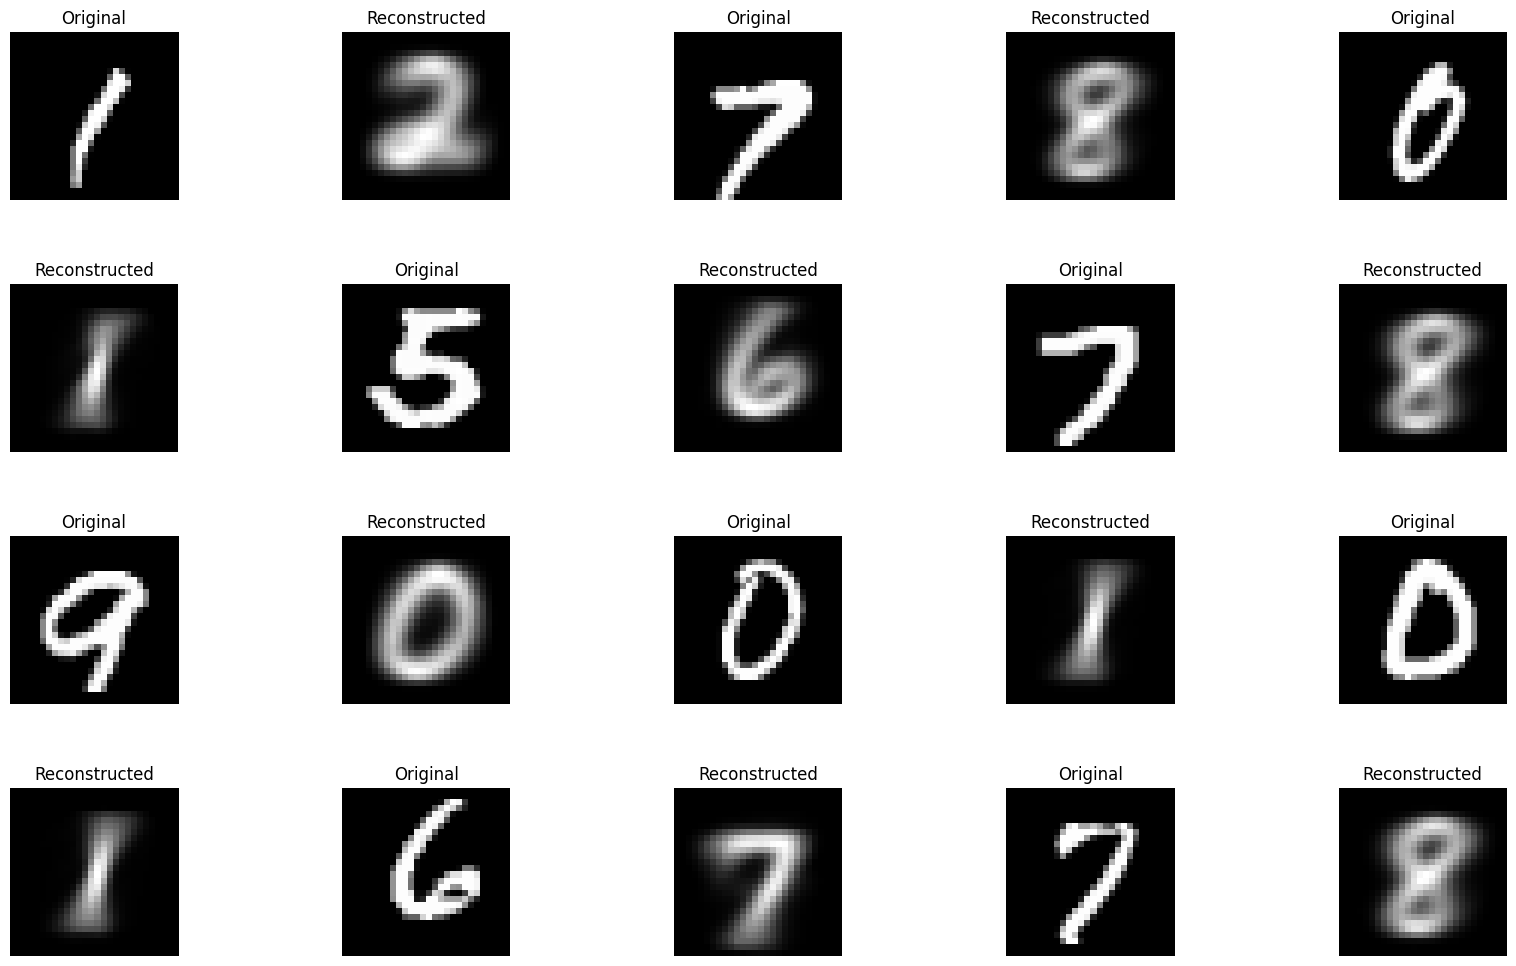

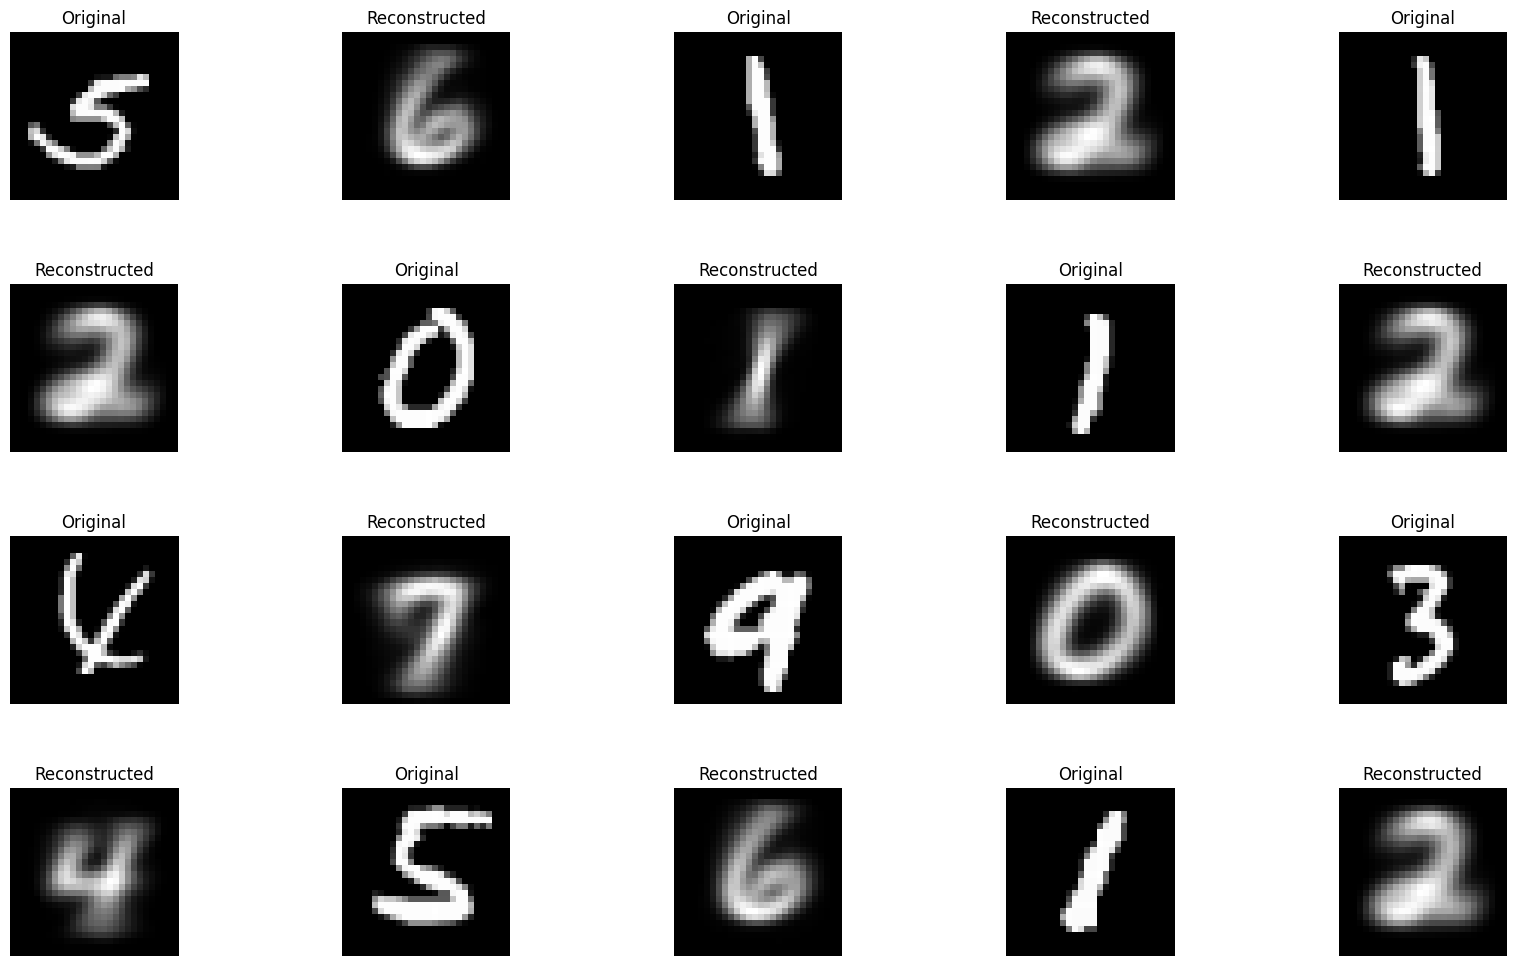

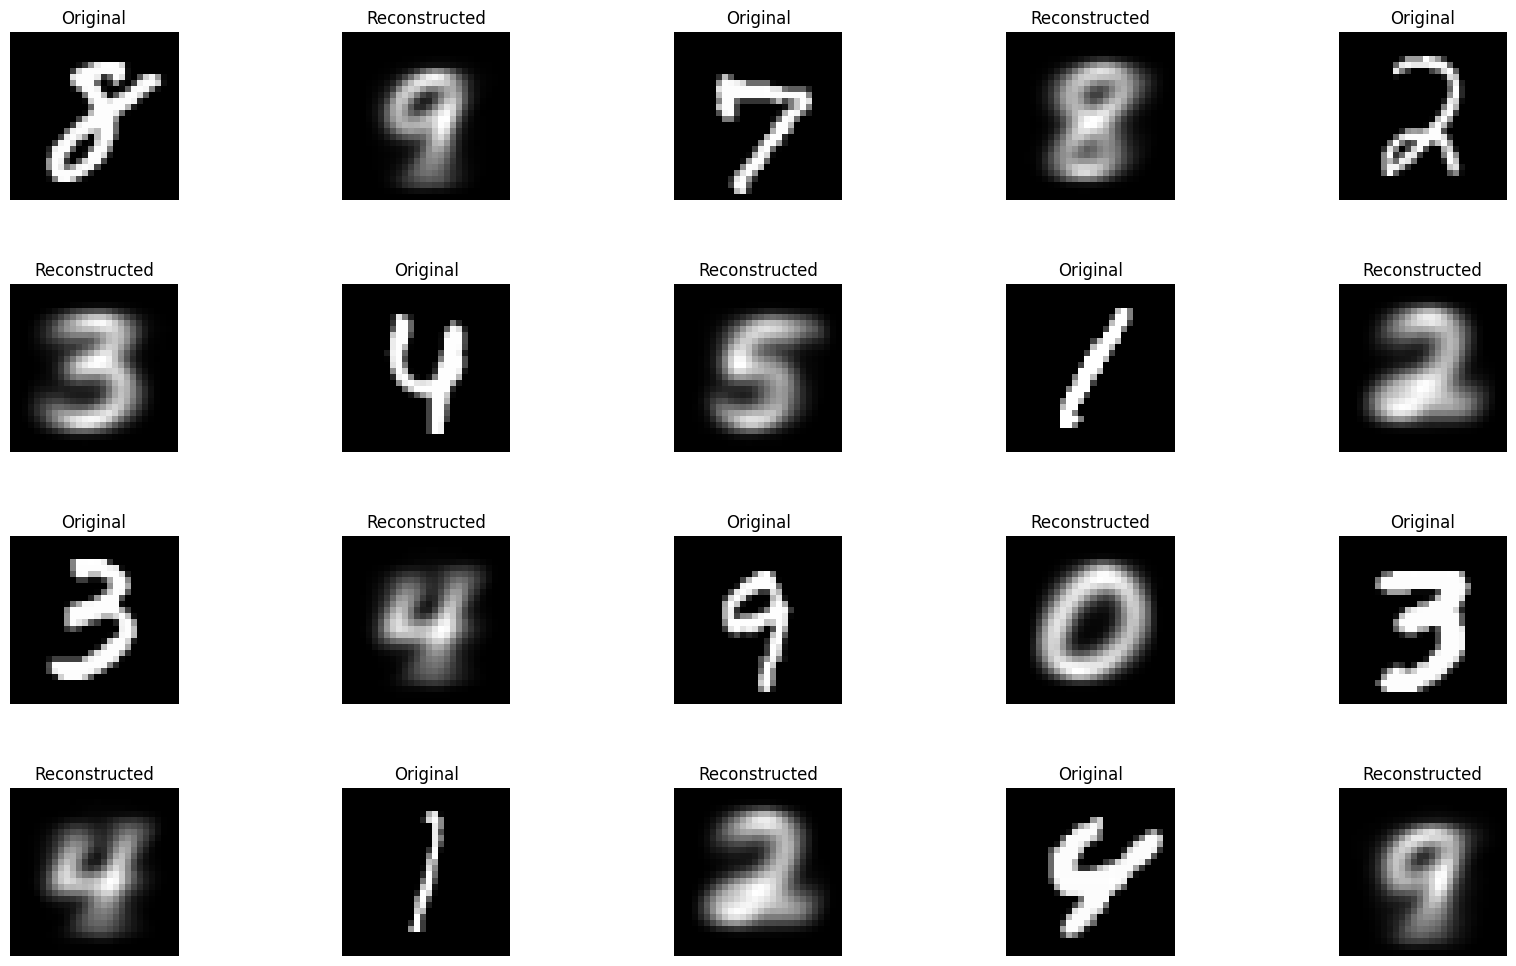

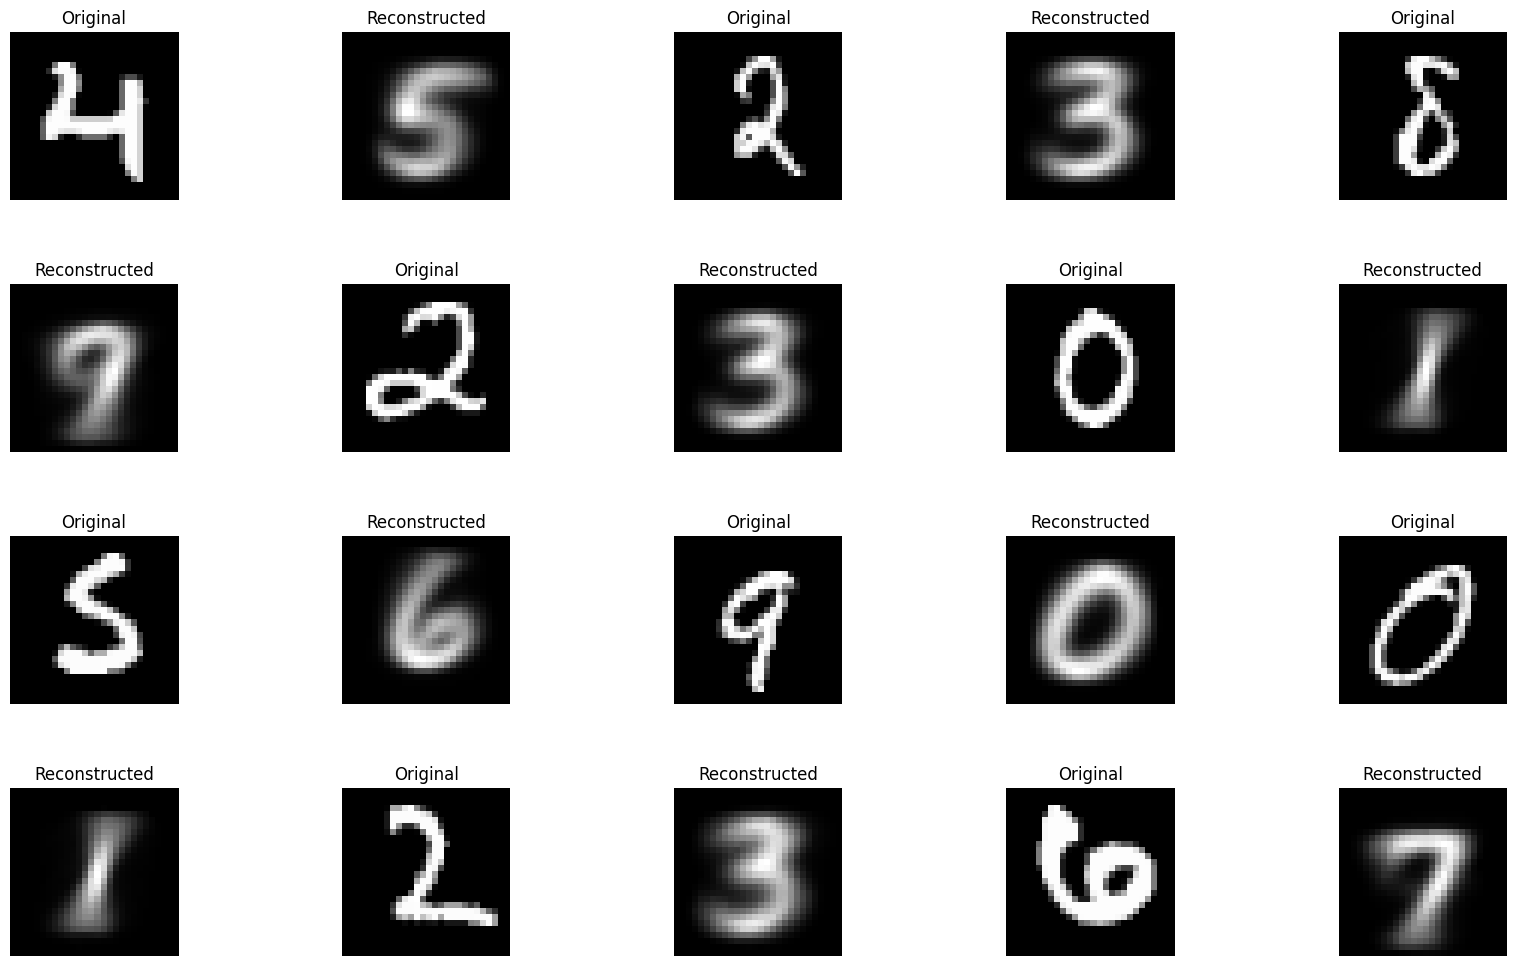

In [11]:
import matplotlib.pyplot as plt

num_examples = 40

test_loader = DataLoader(X_test, batch_size=num_examples, shuffle=True)

for batch_idx, input_data in enumerate(test_loader):
    input_data = input_data.to(device)
    
    reconstructed = ae(input_data)
    
    input_data = input_data.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()

batch_size = 10  
num_batches = num_examples // batch_size 

for batch in range(num_batches):
    plt.figure(figsize=(20, 12))
    for i in range(batch_size):
        # Plot original image
        plt.subplot(4, 5, 2 * i + 1)
        plt.imshow(input_data[batch * batch_size + i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot reconstructed image
        plt.subplot(4, 5, 2 * i + 2)
        plt.imshow(reconstructed[batch * batch_size + i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()
